Here we have used javascript code to stream video in colab file from : 

https://github.com/theAIGuysCode/colab-webcam

After streaming we need to detect face in video, for that we have used FaceNet by :
https://github.com/pik1989/FaceMaskDetection/blob/main/detect_mask_video.py


https://github.com/balajisrinivas/Face-Mask-Detection/blob/master/detect_mask_video.py 

---
---


We have made changes according to our need as we have different dataset and we are using our **own** neural network model trained for mask detection.


*   We need to change the bounding box size for better face detection before passing input to facenet 
*   We dont need BGR2RGB converter as well.

In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import PIL
import io
import html
import time

Below code is for video streaming in colab.

In [2]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [3]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

Function for detecting face and predicting mask is there on the face or not.

In [9]:
from tensorflow.keras.preprocessing.image import img_to_array

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob from it
	(h, w) = frame.shape[:2];
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward();
  
	# initialize our list of faces, their corresponding locations, and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")
   
			# ensure the bounding boxes fall within the dimensions of the frame
			mult = 0.1
			startX = startX - round(startX*mult)
			startY = startY - round(startY*mult)
			endX = endX + round(endX*mult)
			endY = endY + round(endY*mult)
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			#face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face);  #cv2_imshow(face)

			# add the face and bounding boxes to their respective lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all* faces at the same time rather than one-by-one predictions in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32); #print(preds)

	# return a 2-tuple of the face locations and their corresponding locations
	
	return (locs, preds)

Function call for video stream as well as face detection and mask prediction. Other than that bounding box and merging box with video frame code.  

In [10]:
from keras.models import load_model
#from mtcnn.mtcnn import MTCNN

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 

# load our serialized face detector model from disk
prototxtPath = "/content/drive/MyDrive/Mask_Detection_Data/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/Mask_Detection_Data/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
model = load_model("/content/drive/MyDrive/Mask_Detection_Data/mask-detection.hdf5")

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # detect faces in the frame and determine if they are wearing a
	  # face mask or not
    (locs, preds) = detect_and_predict_mask(img, faceNet, model)

    # loop over the detected face locations and their corresponding
    # locations
    for (box, pred) in zip(locs, preds):
      # unpack the bounding box and predictions
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred

      # determine the class label and color we'll use to draw
      # the bounding box and text
      if mask > withoutMask :
        label = "Mask" 
        color = (0, 255, 0)
      else :
        label ="No Mask"
        color = (255, 0, 0)

      # include the probability in the label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

      # display the label and bounding box rectangle on the output
      # frame
      bbox_array = cv2.putText(bbox_array, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      bbox_array = cv2.rectangle(bbox_array, (startX, startY), (endX, endY), color, 2)
      
    # show the output frame
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes    

<IPython.core.display.Javascript object>

'\n    # if the `q` key was pressed, break from the loop\n    if key == ord("q"):\n      break\n\n# do a bit of cleanup\ncv2.destroyAllWindows()\n'

Code below is for face mask detection for an **Image**.

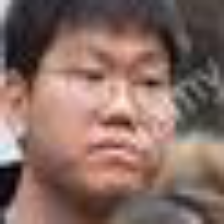

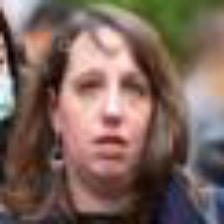

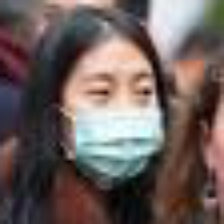

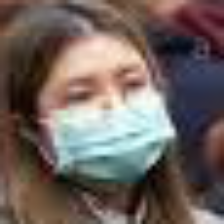

[[7.5053205e-05 9.9992490e-01]
 [4.0982643e-04 9.9959022e-01]
 [9.9947613e-01 5.2388280e-04]
 [9.9987161e-01 1.2839363e-04]]


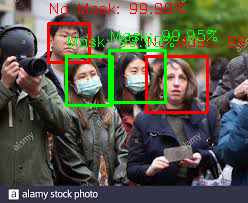

In [ ]:
"""
from skimage import io
from keras.models import load_model

# initialze bounding box to empty
bbox = ''
count = 0 

# load our serialized face detector model from disk
prototxtPath = "/content/drive/MyDrive/Mask_Detection_Data/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/Mask_Detection_Data/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
model = load_model("/content/drive/MyDrive/Mask_Detection_Data/mask-detection.hdf5")

# convert JS response to OpenCV Image
img = io.imread("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ1J-5gikrv4foPSHPtR0EmAr8ekdzPgqP81A&usqp=CAU")

#https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQimt_L7TCFLb1FzRINRUdNT1Cwy-0qqwM8BQ&usqp=CAU
##https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ1J-5gikrv4foPSHPtR0EmAr8ekdzPgqP81A&usqp=CAU
#https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRlnZooP04VDPH0u0SVYMP8UwmZio8hkTBXlg&usqp=CAU
#https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTQy_ygLGGaiIJYtzCSLvRqKN_bPPdc-fypJA&usqp=CAU
#https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaEZHTPl11FFauOC6AMy6Ae0CNJa-7-CXO7w&usqp=CAU
#https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRuNDtKzVRJ6c33su2BoVQ_aZ8ndcKuBqplUw&usqp=CAU
#https://images.unsplash.com/photo-1512479064533-47d51d07bb93?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MjJ8fG1hc2t8ZW58MHx8MHx8&ixlib=rb-1.2.1&w=1000&q=80

# grayscale image for face detection
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# detect faces in the frame and determine if they are wearing a
# face mask or not
(locs, preds) = detect_and_predict_mask(img, faceNet, model)

# loop over the detected face locations and their corresponding
# locations
for (box, pred) in zip(locs, preds):
  # unpack the bounding box and predictions
  (startX, startY, endX, endY) = box
  (mask, withoutMask) = pred

  # determine the class label and color we'll use to draw
  # the bounding box and text
  label = "Mask" if mask > withoutMask else "No Mask"
  color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

  # include the probability in the label
  label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

  # display the label and bounding box rectangle on the output
  # frame
  cv2.putText(img, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.50, color, 1)
  cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)

cv2_imshow(img)
"""